# Machine Learning met Python

In dit onderdeel kijken we naar een fractie van de mogelijkheden die Python biedt voor machine learning. De Open Source Software community heeft een grote rol gespeeld in het neerzetten van een interface, bovenop numpy en scipy, met een hoop eenheid en gebruiksgemak. Let wel, vanwege het open source karakter is het nog wel eens aan verandering onderhevig. Over het algmeen worden deze veranderingen aangekondigd met warnings ruim voordat de oude code niet meer werkt, maar houd er rekening mee dat als je meer dan een jaar niet met software hebt gewerkt en de packages ververst, dat code dan wellicht niet meer helemaal werkt.

We zullen kijken naar supervised en unsupervised learning technieken met scikit-learn. Daarna kijken we naar de mogelijkheden van Tensorflow (met Keras frontend) voor (diepe) neurale netwerken.

scikitlearn (te importeren als sklearn) bevat allerlei functionaliteiten in allerlei packages. Bijvoorbeeld:
- datasets: het verkrijgen van data
- linear_models: bevat lineaire modellen
- neighbors: nearest neighbor modellen
- svm: Support Vector Machines
- model_selection: functionaliteit om modellen te beoordelen
- tree: beslisbomen etc.
- preprocessing: voorbereiden van data

In [1]:
# ALgemene imports. Imports die specifiek horen bij de voorbeelden worden ter plekke ingeladen, voor de duidelijkheid van het voorbeeld.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sns.set_style('white')
sns.set_context('poster')

## Supervised machine learning

Supervised learning is het trainen van een algoritme om een *bekend antwoord* te reproduceren en komt voornamelijk in 2 smaken:
- Classificatie: het voorspellen van labels, op basis van andere data features.
- Regressie: het voorspellen van een getalswaarde voor een grootheid op basis van andere data features.

### Logistische regressie als voorbeeld

Hier zullen we kijke naar een uitgewerkt voorbeeld van de logistische regressie. We houden het bij een simpel voorbeeld dat we makkelijk kunnen visualiseren. In de package "sklearn.datasets" zit "makeblobs" waarbij je blobs van data maakt die bij elkaar horen en een label krijgen. Logistische regressie is een lineair model voor classificatie van die labels en zit dus in "sklearn.linear_model".

X, aantal samples en aantal features: (100, 2)
y aantal samples: (100,)

Eerste 5 samples:
 [[ 4.21850347  2.23419161]
 [ 0.90779887  0.45984362]
 [-0.27652528  5.08127768]
 [ 0.08848433  2.32299086]
 [ 3.24329731  1.21460627]]

Eerste 5 labels: [1 1 0 0 1] 

De twee blobs, kleur correspondeert met het label:


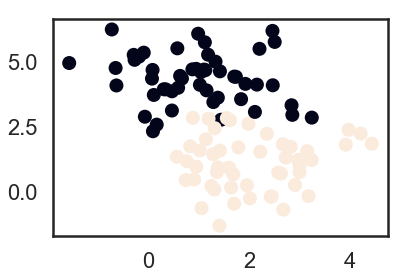

In [2]:
from sklearn.datasets import make_blobs

# Maak twee blobs. X krijgt 2D coordinaten en y is een label voor bij welke blob de data hoort.
X, y = make_blobs(centers=2, random_state=0)

print('X, aantal samples en aantal features:', X.shape)
print('y aantal samples:', y.shape)

print('\nEerste 5 samples:\n', X[:5, :])
print('\nEerste 5 labels:', y[:5], '\n')

# En in een simpel plaatje
plt.scatter(X[:,0], X[:,1], c=y);
print("De twee blobs, kleur correspondeert met het label:")

Omdat het wel blijkt dat alleen de y-variabele in dat plaatje echt belangrijk is, kijken we eerst naar een voorbeeld waarin we alleen het label proberen te voorspellen als functie van y:

In [3]:
x  =  np.reshape(X[:,1], (-1, 1))          # Die truc met reshape is nodig omdat de regresse een tweedimensionale data container verwacht. Zie de -1!
print(np.shape(x))
print(np.shape(y))

(100, 1)
(100,)


In [4]:
# Laadt en initialiseer de lineaire regressie
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

Op dit moment bestaat er een instantie van een logistisch regressie-object. Deze heeft nog niks gedaan, maar er zijn wel een hoop dingen die nu gedaan kunnen worden. In de eerste plaats kun je een model fitten, met de "fit()" methode. Nadat dat gedaan is kun je het model ook evalueren. "score()" is de methode die je daarvoor gebruikt en in het geval van een logistische regressie krijg je dan de fractie van labels die je goed hebt voorspeld. Met "predict(x)" kun je voorspellingen van je model voor (nieuwe) datapunten berekenen.

In [5]:
classifier.fit(x, y)
voorspelling_van_het_model = classifier.predict(x)
classifier.score(x,y)  # R**2

0.94

Je kunt ook de logistische functies die je daadwerkelijk hebt gefit bekijken. Voor elk punt krijg je een probability dat het datapunt een bepaald label heeft. Deze krijg je door de methode "predict_proba()" aan te roepen op een array getallen. Als je twee mogelijke labels had resulteert dat dus in een array met net zoveel rijen als je inputvector en twee kolommen (waarvan de waarden optellen tot 1):

(100, 2)


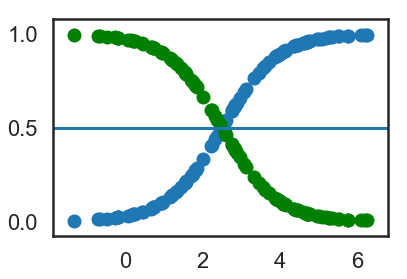

In [6]:
# De waarschijnlijkheden van de beide labels (tellen uiteraard beide op tot 1)
print(np.shape(classifier.predict_proba(x)))
plt.scatter(x, classifier.predict_proba(x)[:,0])
plt.scatter(x, classifier.predict_proba(x)[:,1], c='green')
plt.axhline(y=0.5);

De logistische regressie, zoals vele andere modellen, kan een willekeurig aantal dimensies aan in je inputdata, en kan ook meer dan twee labels voorspellen. HIer zie je het voorbeeld uitgewerkt voor de oorspronkelijke dataset met twee dimensies in de inputarray, en nog steeds twee mogelijke labels.

0.92
(100, 2)


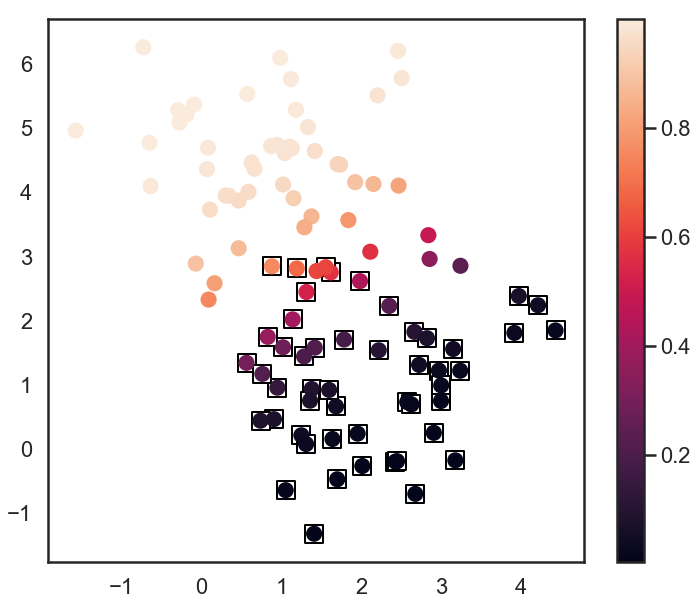

In [7]:
# Nu even op de 2D dataset. Helpt dat?
classifier.fit(X, y)
print(classifier.score(X,y))

print(np.shape(classifier.predict_proba(X)))
plt.figure(figsize=(12, 10))
plt.scatter(X[y==1,0], X[y==1,1], s=300, marker='s', c='white', edgecolors='black')
plt.scatter(X[:,0], X[:,1], c=classifier.predict_proba(X)[:,0], s=200)
plt.colorbar();

## Unsupervised machine learning
Unsupervised machine learning is een klasse van modellen die je kunt trainen, waarbij *niet* van te voren een juist antwoord bekend is. Wat valt er dan te trainen? Ook unsupervised machine learning komt in grofweg in twee varianten:
- Dimensiereductie en patroonherkenning: in datasets met zeer veel dimensies zit vaak wel het een en ander aan structuur. Deze modellen zijn ervoor om je te helpen zulke structuren te vinden, maar ook om je dataset te transformeren naar een dataset met veel minder dimensies, zonder dat je daarmee veel "inzicht" over je data verliest.
- Clustering en segmentatie: in grote datasets wil het nog wel eens gebeuren dat verschillende observaties clusteren in kliekjes. Deze klasse van modellen is ervoor om zulke kliekjes op te sporen.

### k-means clustering als een voorbeeld van unsupervised learning
Als voorbeeld kijken we naar een veelgebruikt clustering-algoritme: k-means. We maken opnieuw gebruik van make_blobs om ditmaal 3 blobs te maken, die we met behulp van k-means willen terugvinden.


(100, 2)


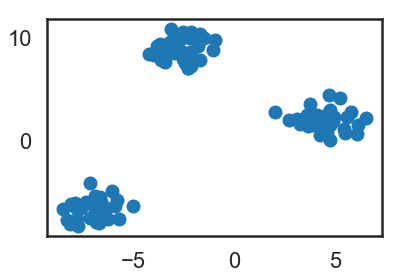

In [8]:
X, y = make_blobs(random_state=42)
print(X.shape)

plt.scatter(X[:, 0], X[:, 1]);

KMeans vinden we in sklearn.cluster en bij het maken van de instantie kun je meegeven hoeveel clusters er moeten worden gevonden. Vaak weet je dat vantevoren niet. In het geval van unsupervised learning is het veelal experimenteren tot je de juiste "hyperparameters" (de parameters die een model sturen) hebt gevonden:

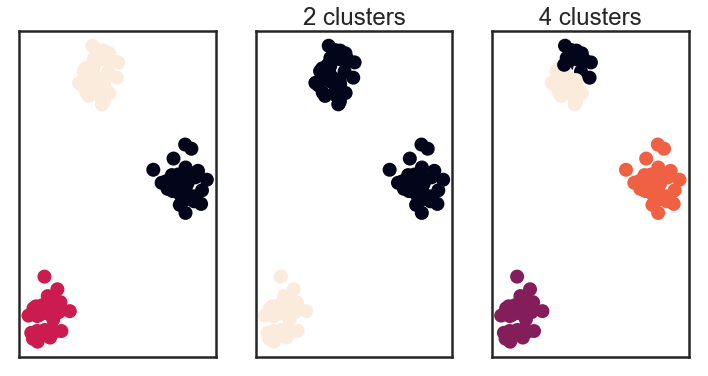

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.xticks([])
plt.yticks([]);

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=labels);
plt.title("2 clusters")
plt.xticks([])
plt.yticks([]);

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title("4 clusters")
plt.xticks([])
plt.yticks([]);


Ook bij het voorkomen van clusters van verschillende afmetingen (of compactheid) kan KMeans in de problemen komen. Blijf experimenteren!

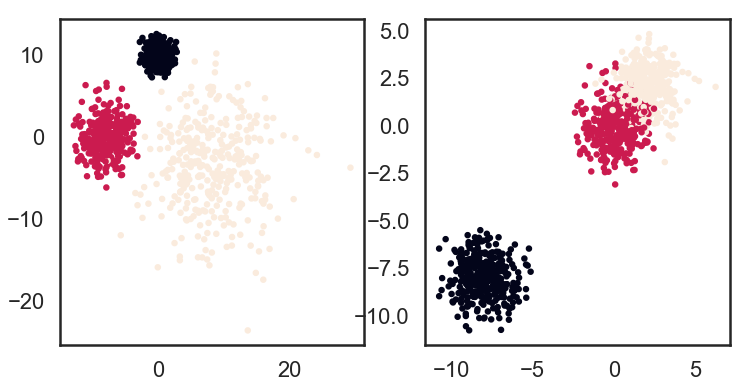

In [10]:
X1, y1 = make_blobs(random_state=101, cluster_std=[1, 2, 5], centers=[[0, 10],[-8, 0], [8,-4]], n_samples=1000, )
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=20)
X2, y2 = make_blobs(random_state=101, centers=[[-8, -8],[0, 0], [2,2]], n_samples=1000, )
plt.subplot(122)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=20);

## De MNIST hand-written digits dataset
Als voorbeeld kijken we naar de "MNIST hand-written digits" dataset, een veelgebruikte dataset voor tutorials over neurale netwerken. Deze wordt hieronder eerst gedownload (tenzij je hem op de aangegeven plek al hebt) en visueel geinspecteerd. Het bevat 70k plaatjes van 784 pixels (28x28) die een handgeschreven getal laten zien, met bijbehorend label (0-9).

In [11]:
from sklearn.datasets import fetch_mldata
# Data wordt subdirectory data opgeslagen, en gedownload als deze nog niet bestaat.
mnist = fetch_mldata("MNIST original", data_home='./data/')  

X, y = mnist.data / 255., mnist.target

print("Dimensies van X:", X.shape)
print("Dimensies van y:", y.shape)

Dimensies van X: (70000, 784)
Dimensies van y: (70000,)


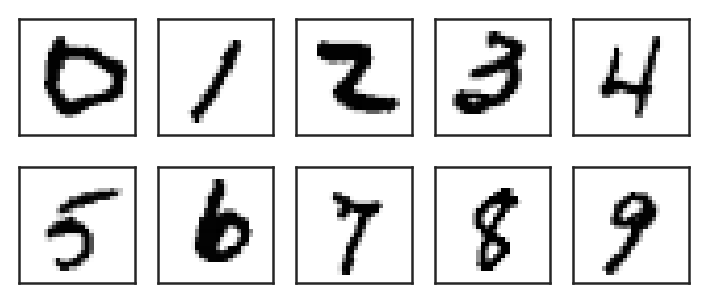

In [12]:
# Zoals je wellicht opvalt zijn er 784 pixels, eat toevallig 28**2, de "shape" van de plaatjes 
imsize = 28

# Bekijk van elk getal een random voorbeeld. Als je deze cell meerdere keren uitvoert krijg je steeds een nieuwe serie. 
plt.figure(figsize=[12, 5])
for target in range(10):
    deze = np.random.choice(np.where(y == target)[0])
    number = np.reshape(np.array(X[deze]), [imsize, imsize])
    pp = plt.subplot(2, 5, target+1)
    pp.imshow(number, cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

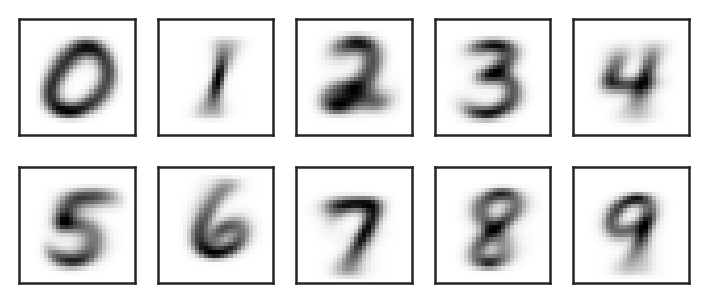

In [13]:
# We kunnen ook het "gemiddelde plaatje" van elk cijfer laten zien.
# Dit komt min of meer overeen met hetgeen we het model gaan trainen!

plt.figure(figsize=[12, 5])
for target in range(10):
    number = np.reshape( X[np.where(y==target)].mean(axis=0) , [imsize, imsize])
    pp = plt.subplot(2, 5, target+1)
    pp.imshow(number, interpolation='nearest', cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

### Een logistische regressie met heel veel variabelen - train_test_split()

Om te laten zien dat logistische regressie ook gewoon werkt als we 784 input features hebben en niet 2, maar 10 mogelijke labels om te voorspellen, doen we dat eerst. Daarbij introduceren we meteen een methode voor onafhankelijke evaluatie van je model: we splitsen de dataset in een *training set* (waarop het model getraind wordt) en een *test set* (die niet gebruikt wordt voor training, maar waarop je dan onafhankelijk de performance van je model kunt testen).

In [14]:
labels = y
features = X

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Het splitsen in een training en test set gebeurt hier. Check de documentatie!
xtr, x, ytr, y = train_test_split(features, labels, test_size=0.3)
clf = LogisticRegression()

In [16]:
# Performance is over het algmeen beter op de training set
clf.fit(xtr, ytr)
print(clf.score(xtr, ytr))
print(clf.score(x, y))

0.9292040816326531
0.9189047619047619


De confusion matrix is een methode om bij een model dat veel verschillende labels probeert te voorspellen na te gaan welke labels goed gaan en welke mogelijk met elkaar verward worden.

/home/marcel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


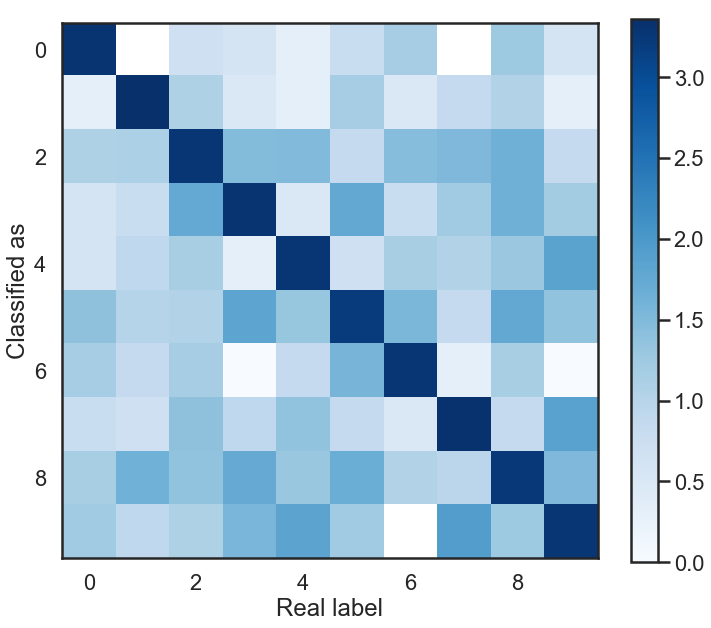

In [17]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(confusion_matrix(y, clf.predict(x))), interpolation='nearest', cmap='Blues')
plt.xlabel("Real label")
plt.ylabel("Classified as")
plt.colorbar();

## Neurale netwerken

Neurale netwerken zijn eigenlijk een soort kettingreactie van "logistische regressie"-achtige modellen via hidden layers (zie de presentatie).
Zolang we scikit-learn's Multi-layer Perceptron gebruiken kunnen we het hele netwerk in 1 keer definieren. Ook hebben we dan het voordeel dat we de volledig consistente scikit-learn interface kunnen gebruiken zoals we de gewend zijn.


In [18]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

In [19]:
mlp.fit(xtr, ytr)
mlp.score(x, y)

0.9707142857142858

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 50, 50), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=50, tol=1e-4, random_state=1,
                    learning_rate_init=.1 )

mlp.fit(xtr, ytr)
mlp.score(x, y)

Iteration 1, loss = 0.35634415
Iteration 2, loss = 0.11679770
Iteration 3, loss = 0.08316159
Iteration 4, loss = 0.06143322
Iteration 5, loss = 0.04974815
Iteration 6, loss = 0.04119876
Iteration 7, loss = 0.03211504
Iteration 8, loss = 0.02724400
Iteration 9, loss = 0.02260792
Iteration 10, loss = 0.02036602
Iteration 11, loss = 0.01842022
Iteration 12, loss = 0.01752384
Iteration 13, loss = 0.01685500
Iteration 14, loss = 0.01413343
Iteration 15, loss = 0.01788758
Iteration 16, loss = 0.01711961
Iteration 17, loss = 0.01243113
Iteration 18, loss = 0.00802289
Iteration 19, loss = 0.00852063
Iteration 20, loss = 0.00849854
Iteration 21, loss = 0.00699045
Iteration 22, loss = 0.00692595
Iteration 23, loss = 0.00273831
Iteration 24, loss = 0.00130102
Iteration 25, loss = 0.00239693
Iteration 26, loss = 0.00867263
Iteration 27, loss = 0.00686381
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


0.9755714285714285

## Tensorflow via Keras
Tensorflow is een populair pakket voor het werken met (diepe) neurale netwerken. Tensorflow kan nog veel meer, maar hier kijken we vooral naar de Keras front-end, die uitermate geschikt is voor het werken met neurale netwerken. De definitie binnen Keras gaat per laag in het netwerk. Het geeft je meer vrijheid dan sklearn, en is dus navenant meer werk.

Binnen Keras moet je aangeven dat je een serie van lagen van neuronen gaat maken, deze vul je dan vervolgens op met lagen naar je keuze. In het voorbeeld hieronder zijn dat allemaal "dense" (ook wel "fully connected") lagen, maar dit kunnen in principe ook convolutionele lagen, pooling lagen, etc. zijn voor meer geavanceerde architecturen van je neurale netwerk.

In [21]:
import tensorflow as tf

In [22]:
# Met Sequential zet je al je lagen achter elkaar
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
# Door een model te compileren definieer je hoe het netwerk gefit moet gaan worden. 
# Dat gebeurt nog niet.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Pas met de fit() methode gebeurt het fitten, waarna het model ook geevalueerd kan worden.
model.fit(xtr, ytr, epochs=10)
print(model.evaluate(xtr, ytr))
model.evaluate(x, y)

Epoch 1/10
49000/49000 [==============================] - 18s 361us/step - loss: 0.2557 - acc: 0.9243
Epoch 2/10
49000/49000 [==============================] - 18s 376us/step - loss: 0.1066 - acc: 0.9666
Epoch 3/10
49000/49000 [==============================] - 20s 409us/step - loss: 0.0708 - acc: 0.9781
Epoch 4/10
49000/49000 [==============================] - 21s 428us/step - loss: 0.0560 - acc: 0.9824
Epoch 5/10
49000/49000 [==============================] - 23s 460us/step - loss: 0.0435 - acc: 0.9858
Epoch 6/10
49000/49000 [==============================] - 23s 477us/step - loss: 0.0372 - acc: 0.9879
Epoch 7/10
49000/49000 [==============================] - 26s 527us/step - loss: 0.0301 - acc: 0.9902
Epoch 8/10
49000/49000 [==============================] - 29s 588us/step - loss: 0.0261 - acc: 0.9914
Epoch 9/10
49000/49000 [==============================] - 30s 617us/step - loss: 0.0207 - acc: 0.9931
Epoch 10/10
49000/49000 [==============================] - 5s 104us/step
[0.019495

[0.1038905165397016, 0.9748095238095238]

Met een auto-encoder willen we de input array reproduceren. We gebruiken hier een bottleneck-laag van 128 neuronen. Dit is meer dan 6x minder dan de oorspronkelijke dataset. Alle informatie voor het reproduceren van het plaatje zit dus verstopt in de bottleneck-laag.

Let op de net iets andere argumenten in de Sequential(), compile() en vooral fit() methoden!

In [23]:
auto_encoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(784, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(784, activation=tf.nn.relu)
])
auto_encoder.compile(loss=tf.keras.losses.mean_squared_error,
             optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
             metrics = ['accuracy'])

auto_encoder.fit(xtr, xtr, epochs=10, batch_size=256)
print("Training performance:", auto_encoder.evaluate(xtr, xtr))

Epoch 1/10
49000/49000 [==============================] - 16s 330us/step - loss: 0.0570 - acc: 0.0104
Epoch 2/10
49000/49000 [==============================] - 15s 310us/step - loss: 0.0363 - acc: 0.0108
Epoch 3/10
49000/49000 [==============================] - 15s 299us/step - loss: 0.0313 - acc: 0.0111
Epoch 4/10
49000/49000 [==============================] - 15s 299us/step - loss: 0.0287 - acc: 0.0116
Epoch 5/10
49000/49000 [==============================] - 16s 328us/step - loss: 0.0267 - acc: 0.0119
Epoch 6/10
49000/49000 [==============================] - 16s 324us/step - loss: 0.0250 - acc: 0.0119
Epoch 7/10
49000/49000 [==============================] - 15s 315us/step - loss: 0.0239 - acc: 0.0122
Epoch 8/10
49000/49000 [==============================] - 14s 292us/step - loss: 0.0231 - acc: 0.0117
Epoch 9/10
49000/49000 [==============================] - 17s 346us/step - loss: 0.0223 - acc: 0.0124
Epoch 10/10
49000/49000 [==============================] - 16s 329us/step
Training

In [24]:
# Met de gebruikelijke predict() methode kunnen we de gereconstrueerde plaatjes berekenen.
reconstructed = auto_encoder.predict(xtr)

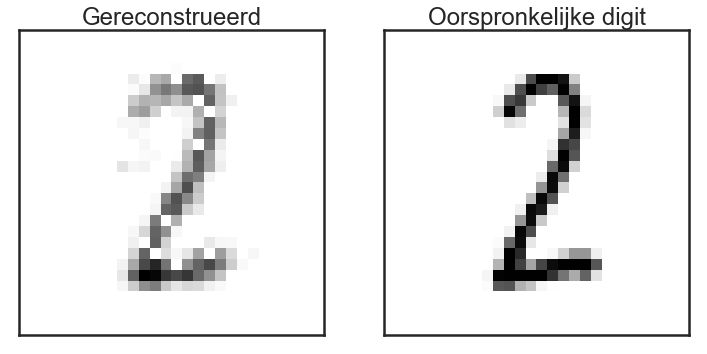

In [25]:
# Deze cell genereert een random paar oorspronkelijke-gereconstrueerde plaatjes.
# Voer hem een paar keer uit voor meerdere voorbeelden!
imsize = 28
aantal_im = len(xtr)
deze = np.random.randint(0, aantal_im)

plt.figure(figsize=(12, 24))
pp = plt.subplot(121)
number = np.reshape(reconstructed[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])
pp.set_title("Gereconstrueerd")

pp = plt.subplot(122)
number = np.reshape(xtr[deze], [imsize, imsize])
pp.imshow(number, cmap='Greys')
pp.set_xticklabels([])
pp.set_yticklabels([])
pp.set_title("Oorspronkelijke digit");


Waar dergelijke exercities nuttig voor kunnen zijn:
- Na het trainen op "clean" images, worden plaatjes met veel ruis ook netjes gereconstrueerd (de-noising auto-encoder).
- Compressie van data.
- Snelle evaluatie van resultaten met de "functions"

## Referenties

Python Data Science Handbook (en al het andere youtube- en blogmateriaal van auteur Jake VanderPlas, zie http://jakevdp.github.io/), geheel in notebooks op github: https://jakevdp.github.io/PythonDataScienceHandbook/. Het pandas boek van Wes McKinney: https://github.com/wesm/pydata-book

Antwoorden op al je vragen (of ze staan er al, of je hebt ze snel) op StackOverflow: https://stackoverflow.com/

Documentatie van de voor data science belangrijke paketten: https://docs.scipy.org/doc/, http://pandas.pydata.org/pandas-docs/stable/

Voor visualisatie gebruiken we matplotlib (https://matplotlib.org/ en de gallery op https://matplotlib.org/gallery/index.html), seaborn (https://seaborn.pydata.org/) en bokeh (https://bokeh.pydata.org/en/latest/).

Verder vind je op YouTube veel praatjes en workshops (vaak met materiaal op github). Let er wel op dat je redelijk recent materiaal bekijkt, sommige van deze paketten zijn nog stevig in ontwikkeling. Op YouTube kun je zoeken naar PyData, (Euro)SciPy, Pycon, Enthought en Numfocus. Dat geeft je een hele hoop materiaal.